In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
from pathlib import Path

import lightning.pytorch as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule, HelioProjectedSDOMLDataModule
from sdofm.pretraining import MAE, SAMAE
from sdofm.finetuning import Autocalibration
from astropy import units as u
import numpy as np

In [5]:
import omegaconf

cfg = omegaconf.OmegaConf.load("../experiments/ablation_virtualeve.yaml")

In [6]:
long_range = 90
lat_range = 90
img_size = 512

In [7]:
data_module = HelioProjectedSDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
    # projection info
    long_range=long_range,
    lat_range=lat_range,
    img_size=img_size,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [8]:
data = next(iter(data_module.train_ds))

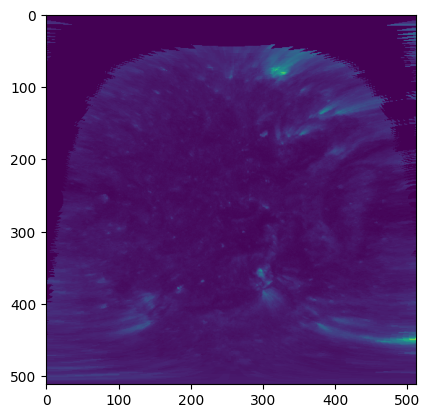

In [10]:
import matplotlib.pyplot as plt

plt.imshow(data[-1, :, :])

# if debugging this, uncomment line in dataloader!

In [36]:
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
from sunpy.map import Map
import sunpy

In [59]:
latitude = np.arange(-lat_range, lat_range, 2 * lat_range / img_size)
longitude = np.arange(-long_range, long_range, 2 * long_range / img_size)
grids = np.meshgrid(latitude, longitude)
xs = grids[0] * u.deg
ys = grids[1] * u.deg

# Loads the heliographic stonyhurst coordinate frame and passes constructed coordinate values.
coords = SkyCoord(xs, ys, frame=frames.HeliographicStonyhurst)

In [37]:
imgs, headers = next(iter(data_module.train_ds))
channels = list(headers.keys())

In [63]:
projected_maps = []
for idx in range(imgs.shape[0]):
    map = Map((imgs[idx, :, :], headers[channels[idx]]))
    x, y = map.world_to_pixel(coords)
    # Converts pixel locations to integers to use as indices to extract data from image array.
    x = x.astype(int)
    y = y.astype(int)
    projected_maps.append(imgs[idx][x, y])

Observatory,SDO
Instrument,AIA 4
Detector,AIA
Measurement,94.0 Angstrom
Wavelength,94.0 Angstrom
Observation Date,2010-09-09 00:06:02
Exposure Time,2.902216 s
Dimension,[512. 512.] pix
Coordinate System,helioprojective
Scale,[4.6853974 4.6853974] arcsec / pix
Reference Pixel,[255.25 255.25] pix

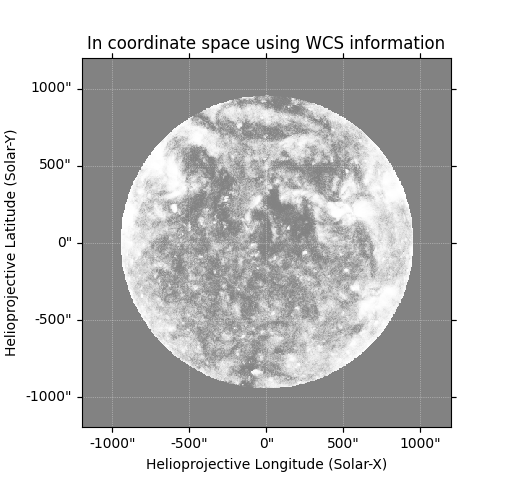
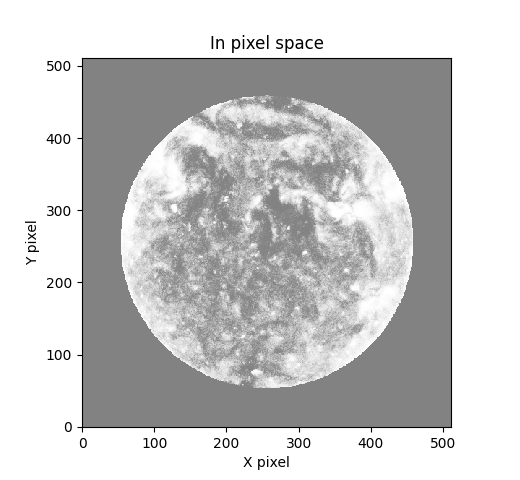
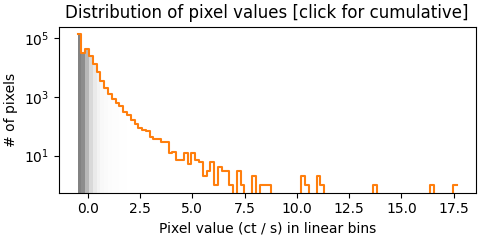
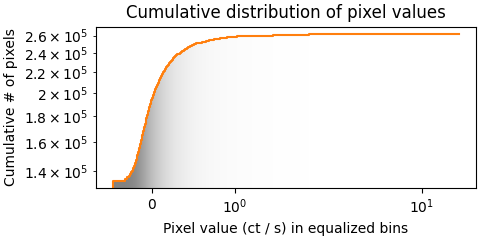

In [43]:
map

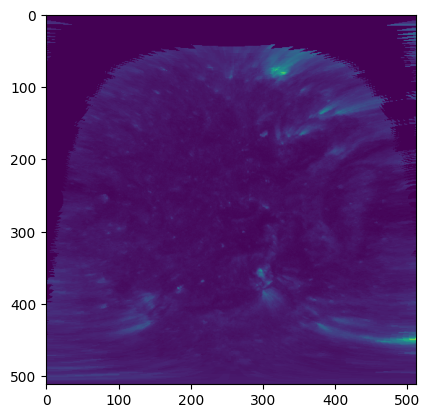

In [65]:
plt.imshow(projected_maps[-1])